# Hierarchical Experiments

### Libraries

In [2]:
# Imports and defaults
import itertools
import joblib
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import block_diag
import scipy.optimize as spo
from scipy import optimize
import time
from collections import defaultdict
import random

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 9
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)
print("%d joblib cores" % joblib.cpu_count())

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

np.random.seed(0)
random.seed(0)

python 3.9.13
matplotlib 3.5.2
8 joblib cores


### Useful functions 

In [3]:
def objective_func(pi, n, K, action_matrix, Sigma_0_inv, sigma) :
    somme_helper = 0
    for i in range(K) :
        somme_helper+= pi[i] * n * np.outer(action_matrix[i], action_matrix[i])
    s, logdet = np.linalg.slogdet(Sigma_0_inv + somme_helper/(sigma**2))
    return - s * logdet


def BG_opt(n, K, action_matrix, Sigma_0_inv, sigma, num_mc = 10) :

    values = np.zeros(num_mc)
    vectors = np.zeros((num_mc, K))

    p_start = np.random.random(K)  #TODO: play with initialization
    p_start = p_start / np.sum(p_start)
    cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
    bounds = tuple([(0, 1) for _ in range(K)])

    for i in range(num_mc) :
        p_start = np.random.random(K)  #TODO: play with initialization
        p_start = p_start / np.sum(p_start)
        result = optimize.minimize(objective_func, p_start, args=(n, K, action_matrix, Sigma_0_inv, sigma), bounds=bounds, constraints=cons)
        w_opt = result.x
        values[i] = result.fun
        vectors[i, :] = w_opt

    w_opt = vectors[np.argmin(values), :]
    return w_opt

def hier_to_linear_params(b, nu, Sigma, sigma_0) :
    K, L = np.shape(b)
    Sigma_bar = np.block([[Sigma, np.zeros((L, K))],[np.ones((K, L)), np.diag(sigma_0**2)]])
    nu_bar = np.concatenate((nu, np.zeros(K)))
    b_bar = np.concatenate((b, np.eye(K)), axis=1)
    return Sigma_bar, nu_bar, b_bar

def norm2_matrix(x, A) :
    return x.T @ A @ x

def fac_compute_Sigma_hat_n(n, omega, A, Sigma_0_inv):
    sum_ = A.T.dot(n * omega[:, None] * A)
    return np.linalg.inv(Sigma_0_inv + sum_)

def fac_Cova_hat_mu_n(sigma, omega, Sigma_0, A, Sigma_hat_n, n):
    K, d = A.shape
    
    helper_ = n * omega * (sigma**2 + np.sum(A.dot(Sigma_0) * A, axis=1))
    variance_terms = A.T.dot(helper_[:, None] * A)
    
    helper1 = np.outer(n*omega, n*omega)
    helper2 = A.dot(Sigma_0)
    helper2 = A.dot(helper2.T)
    helper12 = helper1 * helper2

    A_flatten = A.flatten().reshape(-1, 1)
    outer_products = A_flatten.dot(A_flatten.T)
    outer_products = outer_products.reshape(K, d, K, d)
    outer_products = outer_products.swapaxes(1, 2)
    weighted_outer_products = helper12[:, :, None, None] * outer_products
    covariance_terms = np.sum(weighted_outer_products, axis=(0, 1)) - np.trace(weighted_outer_products, axis1=0, axis2=1)
    
    Cova_hat_mu_n_result = (1/sigma**4) * np.dot(np.dot(Sigma_hat_n, variance_terms + covariance_terms), Sigma_hat_n)
    
    return Cova_hat_mu_n_result


def fac_kappa(A, mu_0, Cov_hat_mu_n, m):
    K, _ = A.shape
    diff_Aj_Am = A - A[m]
    results = np.zeros(K)
    outer_products = np.einsum('ij,ik->ijk', diff_Aj_Am, diff_Aj_Am)
    weighted_mu_0 = np.einsum('ijk,k->ij', outer_products, mu_0)
    norm_mu_0 = np.einsum('ik,k->i', weighted_mu_0, mu_0)
    weighted_diff_Aj_Am = diff_Aj_Am.dot(Cov_hat_mu_n) 
    norm_diff_Aj_Am = np.einsum('ik,ik->i', weighted_diff_Aj_Am, diff_Aj_Am)
    norm_diff_Aj_Am[m] = 1e-50 #To avoid dividing by 0
    results = np.exp(-norm_mu_0 / norm_diff_Aj_Am) 
    results[m] = 1
    return results


def fac_upper_bound_linear(omega, sigma, mu_0, Sigma_0, A, n):
    K, d = A.shape
    result = 0
    Sigma_0_inv = np.linalg.inv(Sigma_0)
    
    Sigma_hat_n = fac_compute_Sigma_hat_n(n, omega, A, Sigma_0_inv)
    Cov_hat_mu_n = fac_Cova_hat_mu_n(sigma, omega, Sigma_0, A, Sigma_hat_n, n)   
    
    ### Computing Lambda_val
    diff_matrix = A[:, np.newaxis] - A
    
    weighted_diff_matrix1 = diff_matrix.dot(Sigma_hat_n)
    norm_diff_Ai_Aj_Sigma = np.einsum('ijk,ijk->ij', weighted_diff_matrix1, diff_matrix)

    weighted_diff_matrix2 = diff_matrix.dot(Cov_hat_mu_n)
    norm_diff_Ai_Aj_Cova = np.einsum('ijk,ijk->ij', weighted_diff_matrix2, diff_matrix)
    
    weighted_diff_matrix3 = diff_matrix.dot(Sigma_0)
    norm_diff_Ai_Aj_Sigma_0 = np.einsum('ijk,ijk->ij', weighted_diff_matrix3, diff_matrix)

    outer_products = np.einsum('ijk,ijl->ijkl', diff_matrix, diff_matrix)
    outer_products = outer_products/(2*norm_diff_Ai_Aj_Sigma_0[:,:,None,None]+1e-50) #Check how to handle Nan issues using helper_stabilizer 
    
    term1 = 1 / np.sqrt(1 + (norm_diff_Ai_Aj_Cova / (norm_diff_Ai_Aj_Sigma + 1e-50)))
    weighted_mu_0 = outer_products.dot(mu_0)
    norm_mu_0 = np.einsum('ijk,k->ij', weighted_mu_0, mu_0)
    term2 = np.exp(-0.5 * norm_mu_0)
    result = term1 * term2

    return np.sum(result) - np.trace(result)

def adjust_multi(w):
  w_new = np.asarray(w).astype('float64')
  return w_new / np.sum(w_new)

def compute_w_opt_one(cons, bounds, sigma, mu_0, Sigma_0, action_matrix, n, params_hier, alpha) :
    
    K, _ = np.shape(action_matrix)
    Sigma_0_hier, b_hier, Sigma_hier, nu_hier = params_hier 
    marginal_variances =  np.array([Sigma_0_hier[i, i] + b_hier[i].T @ Sigma_hier @ b_hier[i] for i in range(K)]) 
    
    p_start = np.random.random(K) 
    p_start = p_start / np.sum(p_start)
    cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
    bounds = tuple([(0, 1) for _ in range(K)])
    w_opt = optimize.minimize(fac_upper_bound_linear, p_start, args=(sigma, mu_0, Sigma_0, action_matrix, n), bounds=bounds, constraints=cons).x

    w_tilde_tmp =  np.array([nu_hier.T @ b_hier[i] for i in range(K)]) * marginal_variances / np.sum(marginal_variances)
    w_tilde = w_tilde_tmp / np.sum(w_tilde_tmp)

    tmp_w_mix = alpha * w_opt + (1 - alpha) * w_tilde 
    w = tmp_w_mix / np.sum(tmp_w_mix)

    return w

def compute_w_opt(sigma, mu_0, Sigma_0, action_matrix, n, params_hier, alpha, num_MC=50) :
   
   cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
   bounds = tuple([(0, 1) for _ in range(K)])
   
   w_opt_matrix = Parallel(n_jobs=-1)(delayed(compute_w_opt_one)(cons, bounds, sigma, mu_0, Sigma_0, action_matrix, n, params_hier, alpha) for ex in range(num_MC))
   w_opt_final = w_opt_matrix[np.argmin([fac_upper_bound_linear(omega, sigma, mu_0, Sigma_0, action_matrix, n) for omega in w_opt_matrix])]
   return adjust_multi(w_opt_final)

### Bandit Environment 

In [5]:
# Bandit environments
class BanditEnvironment(object):
  """Contextual bandit with K arms."""

  def __init__(self, K, theta, sigma):
    self.K = K  # number of arms
    self.theta = np.copy(theta)  # list of reward means
    self.sigma = sigma  # reward noise
    self.best_arm = np.argmax(self.theta)
    self.randomize()

  def randomize(self):
    self.rt = self.theta + self.sigma * np.random.randn(self.K)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def print(self):
    return "Bandit Environment: %d arms" % (self.K)

def evaluate_one(Alg, env, n):
  """One run of a bandit algorithm."""
  alg = Alg(env, n)
  alg.explore(n)
  J_n = alg.get_best_arm()
  return 1 * (J_n != env.best_arm)


def evaluate(Alg, env, n, printout=False):
  """Multiple runs of a bandit algorithm."""
  start = time.time()
  num_exps = len(env)
  error_indicators = Parallel(n_jobs=-1)(delayed(evaluate_one)(Alg, env[ex], n) for ex in range(num_exps))
  error_indicators = np.array(error_indicators)
  error_prob = np.mean(error_indicators)

  if printout:
    print("Evaluating %s" % Alg.print(), end="")
    print(" %.1f seconds" % (time.time() - start))
    print("Probability of error: %.2f +/- %.2f" %(np.mean(error_indicators), np.std(error_indicators) / np.sqrt(num_exps)))

  return error_prob, error_indicators

In [6]:
def evaluate_one_sr(Alg, env, n):
  """One run of a bandit algorithm."""
  alg = Alg(env, n)
  alg.explore(n)
  J_n = alg.get_best_arm()
  return env.theta[env.best_arm] - env.theta[J_n]


def evaluate_sr(Alg, env, n, printout=False):
  """Multiple runs of a bandit algorithm."""
  start = time.time()
  num_exps = len(env)
  error_indicators = Parallel(n_jobs=-1)(delayed(evaluate_one_sr)(Alg, env[ex], n) for ex in range(num_exps))
  error_indicators = np.array(error_indicators)
  error_prob = np.mean(error_indicators)

  if printout:
    print("Evaluating %s" % Alg.print(), end="")
    print(" %.1f seconds" % (time.time() - start))
    print("Probability of error: %.2f +/- %.2f" %(np.mean(error_indicators), np.std(error_indicators) / np.sqrt(num_exps)))

  return error_prob, error_indicators

### Warm-up TS Algorithms

In [7]:
# Thompson sampling algorithms that are only used to estimate the best allocations n_i
class TS:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.mar_sigma_0 = np.copy(env.mar_sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def get_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.mar_sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu_hat = sigma_hat_square * (self.mu_0[i]/(self.mar_sigma_0[i]**2) + self.B[i]/(self.sigma**2))
      self.mu[i] = mu_hat + np.sqrt(sigma_hat_square) * np.random.randn()
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "TS"

class HierTS:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.nu = np.copy(self.env.nu)  # 
    self.Sigma = np.copy(self.env.Sigma)  # 
    self.sigma_0 = np.copy(self.env.sigma_0)  # 
    self.b = np.copy(self.env.b)  
    self.sigma = self.env.sigma  # reward noise

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def get_arm(self):
    # compute cluster means
    Lambda = np.linalg.inv(self.Sigma)
    bar_Lambda_n = np.copy(Lambda)
    for i in range(self.K):
        b_i = self.b[i, :]
        bar_Lambda_n += (self.n_i[i] / (self.n_i[i] * (self.sigma_0[i]**2) + self.sigma**2)) * np.outer(b_i, b_i)
        
    bar_Sigma_n = np.linalg.inv(bar_Lambda_n)
    bar_mu_n = Lambda.dot(self.nu)
    
    for i in range(self.K):
        b_i = self.b[i, :]
        bar_mu_n += (self.B[i]/ (self.n_i[i] * (self.sigma_0[i]**2) + self.sigma**2)) * b_i
    bar_mu_n = bar_Sigma_n.dot(bar_mu_n)
    
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):  
      # arm parameter posterior
      b_i = b[i, :]
      sigma_tilde_square = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_tilde_square = 1/sigma_tilde_square
      b_norm = b_i.dot(bar_Sigma_n).dot(b_i.T)
    
      sigma_hat_square = sigma_tilde_square + ((sigma_tilde_square**2)/(self.sigma_0[i]**4)) * b_norm
      mu_hat = sigma_tilde_square * ((b_i.dot(bar_mu_n))/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
      self.mu[i] = mu_hat + np.sqrt(sigma_hat_square) * np.random.randn()
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "HierTS"

In [8]:
class T3C:
  """
  Based on "Top Two Sampling Revisited, (Jourdan et al., 2022)
  Particularly, we choose the TS-TC procedure, which also corresponds to the T3C algorithm (Shang et al, 2019).
  We do not use TTTS (ie. TS-TC) because as the posterior becomes concentrated, it requires to much sampling and becomes intractable.
  """
  def __init__(self, env, n):
    self.t = 0
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
    self.beta = 1/2 # hyperparameter, we choose 1/2 based on empirical arguments of (Jourdan et al, 2022)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    self.t+=1

  def compute_W(self, i, j) :
    if self.mu_hat[j] > self.mu_hat[i] :
      return 0
    return ((self.mu_hat[i] - self.mu_hat[j])**2) / ( 2 * (self.sigma**2) * ( (1/self.n_i[i]) + (1/self.n_i[j]) ) )
    
  def get_arm(self):
    # compute posterior means
    if self.t < self.K :
      return self.t
    
    else :
      self.mu_hat = np.zeros(self.K)
      self.Sigma_hat = np.eye(self.K)
      for i in range(self.K):
        # arm parameter posterior
        sigma_hat_helper_i = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
        self.Sigma_hat[i, i] = 1/sigma_hat_helper_i  
        self.mu_hat[i] = self.Sigma_hat[i, i] * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))

      # TS leader
      leader = np.argmax(self.mu_hat) 

      # TC challenger
      arm_candidate = np.argmin([self.compute_W(leader, i) for i in range(self.K)])
      if arm_candidate != leader :
        challenger = arm_candidate
      else :
        list_helper = [self.compute_W(leader, i) for i in range(self.K)]
        challenger = list_helper.index(sorted(list_helper)[1])

      u = np.random.uniform(0, 1)
      return leader if (u < self.beta) else challenger # Choose challenger wp beta
    

  """ In case one need to use T3C as a full BAI algorithm (ie not only as a warm-up) """

  def explore(self, n) :
    for t in range(self.n) :
      self.env.randomize()
      arm_t = self.get_arm()
      self.update(arm_t, self.env.reward(arm_t))
  
  def get_best_arm(self):
    # compute posterior means at the end of the final round
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm
  
  @staticmethod
  def print():
    return "T3C"

In [9]:
class TSTCI:
  """
  Based on "Top Two Sampling Revisited, (Jourdan et al., 2022)
  Particularly, we choose the TS-TC procedure, which also corresponds to the T3C algorithm (Shang et al, 2019).
  We do not use TTTS (ie. TS-TC) because as the posterior becomes concentrated, it requires to much sampling and becomes intractable.
  """
  def __init__(self, env, n):
    self.t = 0
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
    self.beta = 1/2 # hyperparameter, we choose 1/2 based on empirical arguments of (Jourdan et al, 2022)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    self.t+=1

  
  def compute_W(self, i, j) :
    if self.mu_hat[j] > self.mu_hat[i] :
      return 0
    return ((self.mu_hat[i] - self.mu_hat[j])**2) / ( 2 * (self.sigma**2) * ( (1/self.n_i[i]) + (1/self.n_i[j]) ) )
    
  def get_arm(self):
    # compute posterior means
    if self.t < self.K :
      return self.t
    
    else :
      self.mu_hat = np.zeros(self.K)
      self.Sigma_hat = np.eye(self.K)
      for i in range(self.K):
        # arm parameter posterior
        sigma_hat_helper_i = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
        self.Sigma_hat[i, i] = 1/sigma_hat_helper_i  
        self.mu_hat[i] = self.Sigma_hat[i, i] * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))

      # TS leader
      leader = np.argmax(self.mu_hat) 

      # TC challenger
      arm_candidate = np.argmin([self.compute_W(leader, i) for i in range(self.K)])
      if arm_candidate != leader :
        challenger = arm_candidate
      else :
        list_helper = [self.compute_W(leader, i) + np.log(self.n_i[i]) for i in range(self.K)]
        challenger = list_helper.index(sorted(list_helper)[1])

      u = np.random.uniform(0, 1)
      return leader if (u < self.beta) else challenger # Choose challenger wp beta
    

  """ In case one need to use TSTCI as a full BAI algorithm (ie not only as a warm-up) """

  def explore(self, n) :
    for t in range(self.n) :
      self.env.randomize()
      arm_t = self.get_arm()
      self.update(arm_t, self.env.reward(arm_t))
  
  def get_best_arm(self):
    # compute posterior means at the end of the final round
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm
  
  @staticmethod
  def print():
    return "TSTCI"

### BAI Algorithms 

In [10]:
# BAI algorithm with uniform allocations
class PI_BAI_Opt:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.mar_sigma_0 = np.copy(env.mar_sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise
    self.w_opt = self.env.w_opt # any arbitrary weigh
    self.n_samples = np.random.multinomial(self.n, self.w_opt)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        #for t in range(self.n_samples[i]):
        for t in range(int(n*self.w_opt[i])):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.mar_sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.mar_sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-Opt"

In [11]:
# BAI algorithm with uniform allocations
class PI_BAI_G_Opt:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.mar_sigma_0 = np.copy(env.mar_sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise
    self.w_optimal_design = self.env.w_optimal_design # any arbitrary weigh
    self.n_samples = np.random.multinomial(self.n, self.w_optimal_design)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        #for t in range(self.n_samples[i]):
        for t in range(int(n*self.w_optimal_design[i])):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.mar_sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.mar_sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-G-Opt"

In [12]:
# BAI algorithm with uniform allocations
class PI_BAI_Uni:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.mar_sigma_0 = np.copy(env.mar_sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(n//self.K):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.mar_sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.mar_sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-Uni"

In [13]:
# Bayesian Successive Halving
class BayesElim:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.mar_sigma_0 = np.copy(env.mar_sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise

    self.S_r = np.arange(self.K)
    self.R = np.log2(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        self.clear_history()
        for i in self.S_r:
            for t in range(int(n//(self.R * len(self.S_r)))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))
            mu = self.compute_posterior_mean()
            
        self.S_r = np.argsort(mu)[::-1][:int(np.ceil(len(self.S_r)//2))]
                
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      sigma_hat_helper = 1/(self.mar_sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu[i] = sigma_hat_square * (self.mu_0[i]/(self.mar_sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    return mu
          
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "BayesElim"

In [14]:
# Successive Halving
class SH:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.S_r = np.arange(self.K)
    self.R = np.log2(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        self.clear_history()
        for i in self.S_r:
            for t in range(int(n//(self.R * len(self.S_r)))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))
            mu = self.compute_posterior_mean()
        self.S_r = np.argsort(mu)[::-1][:int(np.ceil(len(self.S_r)//2))]
                
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      mu[i] = self.B[i] / self.n_i[i]
    return mu
          
    
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "SH"

In [15]:
# Successive Rejects
class SR:
  """
  Based on (Audibert et al, 2010)
  """
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.n0 = 0
    self.log_bar = 0.5 + np.sum([1/i for i in range(2, self.K + 1)])
    self.S_r = np.arange(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

    self.nb_pulls_SR = np.zeros(self.K + 1)
    self.nb_pulls_SR[0] = self.n0
    for i in range(1, self.K+1) :
       self.nb_pulls_SR[i] = np.ceil( (self.n - self.K) / ( self.log_bar * (self.K + 1 - i) ) )

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1

  def explore(self, n):
    # explore actions
    for r in range(self.K-1):
      #self.clear_history()    SR does not clear its history
      for i in self.S_r :
        for t in range( int(self.nb_pulls_SR[r+1] - self.nb_pulls_SR[r]) ) :
          self.env.randomize()
          self.update(i, self.env.reward(i))
      mu = self.B / self.n_i #self.compute_empirical_mean()
      self.S_r = np.argsort(mu)[::-1][:-(r+1)]

  def get_best_arm(self):
    return self.S_r[0] # there is only one arm left in S_r at this stage.

  @staticmethod
  def print():
    return "SR"

In [16]:
# BAI-TS algorithm that learns the allocations n_i by running TS in a warm-up phase
class PI_BAI_TS:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.mar_sigma_0 = np.copy(env.mar_sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
            
    ts_alg = TS(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = ts_alg.get_arm()
        ts_alg.update(arm, env.reward(arm))
    self.w_ts = ts_alg.n_i / self.n_w    
    self.n_samples = np.random.multinomial(self.n, self.w_ts)    

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.mar_sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.mar_sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-TS"

In [17]:
# HierBAI-TS algorithm corresponds to BAI-TS that considers the hierarchical structure
class PI_BAI_meTS:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget
    self.nu = np.copy(self.env.nu)  # 
    self.Sigma = np.copy(self.env.Sigma)  # 
    self.sigma_0 = np.copy(self.env.sigma_0)  # 
    self.b = np.copy(self.env.b)  
    self.sigma = self.env.sigma  # reward noise
            
    ts_alg = HierTS(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = ts_alg.get_arm()
        ts_alg.update(arm, env.reward(arm))
    self.w_ts = ts_alg.n_i / self.n_w        
    self.n_samples = np.random.multinomial(self.n, self.w_ts)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute cluster means
    Lambda = np.linalg.inv(self.Sigma)
    bar_Lambda_n = np.copy(Lambda)
    for i in range(self.K):
        b_i = self.b[i, :]
        bar_Lambda_n += (self.n_i[i] / (self.n_i[i] * (self.sigma_0[i]**2) + self.sigma**2)) * np.outer(b_i, b_i)
        
    bar_Sigma_n = np.linalg.inv(bar_Lambda_n)
    bar_mu_n = Lambda.dot(self.nu)
    
    for i in range(self.K):
        b_i = self.b[i, :]
        bar_mu_n += (self.B[i]/ (self.n_i[i] * (self.sigma_0[i]**2) + self.sigma**2)) * b_i
    bar_mu_n = bar_Sigma_n.dot(bar_mu_n)
    
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):  
      # arm parameter posterior
      b_i = b[i, :]
      sigma_tilde_square = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_tilde_square = 1/sigma_tilde_square
      b_norm = b_i.dot(bar_Sigma_n).dot(b_i.T)
    
      sigma_hat_square = sigma_tilde_square + ((sigma_tilde_square**2)/(self.sigma_0[i]**4)) * b_norm
      mu_hat = sigma_tilde_square * ((b_i.dot(bar_mu_n))/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
      self.mu[i] = mu_hat
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-meTS"

In [18]:
class PI_BAI_T3C:
  """
  This is a variant of TTTS and corresponds to TS-TC of (Jourdan et al, 2023). It also corresponds to (Shang et al, 2020). Note that the latter offers a closed-form 
  formula for the transportation cost for Gaussian distributions.
  """
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget TODO: check if it does not affect anything
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
            
    T3C_alg = T3C(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = T3C_alg.get_arm()
        T3C_alg.update(arm, env.reward(arm))
    self.w_ttts = T3C_alg.n_i / self.n_w  
    self.n_samples = np.random.multinomial(self.n, self.w_ttts) 

    # sufficient statistics : NO DISCARD
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-T3C"

In [19]:
class PI_BAI_TSTCI:
  """
  This is a variant of TTTS and corresponds to TS-TCI of (Jourdan et al, 2023). 
  """
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget TODO: check if it does not affect anything
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
            
    TSTCI_alg = T3C(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = TSTCI_alg.get_arm()
        TSTCI_alg.update(arm, env.reward(arm))
    self.w_tstci = TSTCI_alg.n_i / self.n_w  
    self.n_samples = np.random.multinomial(self.n, self.w_tstci) 

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-TSTCI"

## Experiments: Varying the budget n

Running experiments with n = 150
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.05 0.05 0.05]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 200
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01
 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 250
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01
 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:41: RuntimeWarning: overflow encountered in exp
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866

Running experiments with n = 300
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 350
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 400
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 450
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.01 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 500
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.01 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 550
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

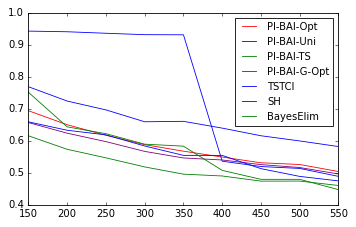

In [21]:
np.random.seed(0)
random.seed(0)

sigma = 1 # observation noise
num_runs = 10000 # number of experiments

algs = [
  ("PI_BAI_Opt", "red", "-", "PI-BAI-Opt"),
  ("PI_BAI_Uni", "blue", "-", "PI-BAI-Uni"),
  ("PI_BAI_meTS", "green", "-", "PI-BAI-TS"),
  ("PI_BAI_G_Opt", "purple", "-", "PI-BAI-G-Opt"),
  ("TSTCI", "blue", "-", "TSTCI"),
  ("SH", "blue", "-", "SH"),
  ("BayesElim", "green", "-", "BayesElim"),
]


exps = [
  {"K":60, "L":10}
]

budgets_ = np.arange(150, 600, 50)

for exp in exps:
    
  # set parameters of the experiment
  for attr, val in exp.items():
    globals()[attr] = val
  results_ = defaultdict(list) 
  # generate cluster prior means and mixing weights
  nu = np.linspace(0, 2, L) 

  b = np.random.random((K, L))
  row_sums = b.sum(axis=1)
  b = b / row_sums[:, np.newaxis] # normalization: each b_i has coordinates that sums to 1 (mixture)

  Sigma = np.diag(np.linspace(0.1**2, 0.5**2, L)) # Variances
  sigma_0 = np.linspace(0.1, 0.5, K) # Standard deviations

  params_hier = np.diag(sigma_0**2), b, Sigma, nu 

  for n in budgets_:
    
      print('Running experiments with n =', n)
      n_w = K # warm-up rounds for TS
      
      # bandit environments
      envs = []

      # Modified linear parameters
      Sigma_bar, nu_bar, b_bar = hier_to_linear_params(b, nu, Sigma, sigma_0)
      Sigma_bar_inv = np.linalg.inv(Sigma_bar)
      w_optimal_design = BG_opt(n, K, b_bar, Sigma_bar_inv, sigma, num_mc = 1).astype(float)
      w_optimal_design /= w_optimal_design.sum()
      print(np.round(w_optimal_design, 2))

      w_optim = compute_w_opt(sigma, nu_bar, Sigma_bar, b_bar, n, params_hier, alpha=0.1, num_MC=100) .astype(float)
      w_optim /= w_optim.sum()

      for run in range(num_runs):
        mu = np.random.multivariate_normal(nu, Sigma)  
        # generate arm means 
        theta = np.random.multivariate_normal(b.dot(mu), np.diag(sigma_0**2))

        # initialize bandit environment
        env = BanditEnvironment(K, theta, sigma)

        # pass parameters for algorithm initialization (not used in simulation)
        env.nu = np.copy(nu)
        env.Sigma = np.copy(Sigma)
        env.b = np.copy(b)
        env.sigma_0 = np.copy(sigma_0)
        env.w_optimal_design = w_optimal_design

        # compute marginal prior means  
        env.mu_0 = b.dot(nu)
        mar_sigma_0 = np.copy(sigma_0)
        for i in range(K):
            mar_sigma_0[i] += b[i, :].dot(Sigma).dot(b[i, :].T)
        env.mar_sigma_0 = mar_sigma_0 
        env.mean_mar_sigma_0 = np.mean(env.mar_sigma_0)
        env.n_w = n_w
        envs.append(env)

        env.w_optimal_design = w_optimal_design
        env.w_opt = w_optim

      # simulation
      for alg in algs:
        # all runs for a single algorithm
        alg_class = globals()[alg[0]]
        error_prob, error_indicators = evaluate(alg_class, envs, n)
        results_[alg[3]].append(error_indicators)

np.save('results/hierarchical/fixed_setting_varying_budget_K={}_L={}.npy'.format(K, L), results_)     

for alg in algs:
    plt.plot(budgets_, np.mean(results_[alg[3]], axis=1), label=alg[3], color=alg[1])
plt.legend()

Running experiments with n = 150
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.05 0.05 0.05 0.05]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 200
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.01
 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:41: RuntimeWarning: overflow encountered in exp
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866

Running experiments with n = 250
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01
 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 300
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 350
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.04 0.04 0.04 0.04]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 400
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 450
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 500
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.01 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

Running experiments with n = 550
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.01 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03]


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964155866.py:73: RuntimeWarning: invalid value encountered in sqrt
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_13589/3964

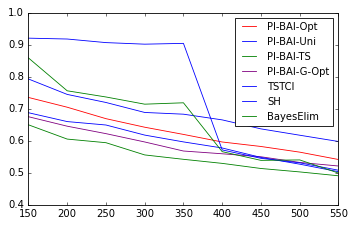

In [22]:
np.random.seed(0)
random.seed(0)

sigma = 1 # observation noise
num_runs = 10000 # number of experiments

algs = [
  ("PI_BAI_Opt", "red", "-", "PI-BAI-Opt"),
  ("PI_BAI_Uni", "blue", "-", "PI-BAI-Uni"),
  ("PI_BAI_meTS", "green", "-", "PI-BAI-TS"),
  ("PI_BAI_G_Opt", "purple", "-", "PI-BAI-G-Opt"),
  ("TSTCI", "blue", "-", "TSTCI"),
  ("SH", "blue", "-", "SH"),
  ("BayesElim", "green", "-", "BayesElim"),
]


exps = [
  {"K":60, "L":10}
]

budgets_ = np.arange(150, 600, 50)

for exp in exps:
    
  # set parameters of the experiment
  for attr, val in exp.items():
    globals()[attr] = val
  results_ = defaultdict(list) 
  # generate cluster prior means and mixing weights
  nu = np.random.uniform(0, 2, size=(L,))

  b = np.random.random((K, L))
  row_sums = b.sum(axis=1)
  b = b / row_sums[:, np.newaxis] # normalization: each b_i has coordinates that sums to 1 (mixture)

  Sigma = np.diag(np.linspace(0.1**2, 0.5**2, L)) # Variances
  sigma_0 = np.linspace(0.1, 0.5, K) # Standard deviations

  params_hier = np.diag(sigma_0**2), b, Sigma, nu 

  for n in budgets_:
    
      print('Running experiments with n =', n)
      n_w = K # warm-up rounds for TS
      
      # bandit environments
      envs = []

      # Modified linear parameters
      Sigma_bar, nu_bar, b_bar = hier_to_linear_params(b, nu, Sigma, sigma_0)
      Sigma_bar_inv = np.linalg.inv(Sigma_bar)
      w_optimal_design = BG_opt(n, K, b_bar, Sigma_bar_inv, sigma, num_mc = 1).astype(float)
      w_optimal_design /= w_optimal_design.sum()
      print(np.round(w_optimal_design, 2))

      w_optim = compute_w_opt(sigma, nu_bar, Sigma_bar, b_bar, n, params_hier, alpha=0.3, num_MC=100) .astype(float)
      w_optim /= w_optim.sum()

      for run in range(num_runs):
        mu = np.random.multivariate_normal(nu, Sigma)  
        # generate arm means 
        theta = np.random.multivariate_normal(b.dot(mu), np.diag(sigma_0**2))

        # initialize bandit environment
        env = BanditEnvironment(K, theta, sigma)

        # pass parameters for algorithm initialization (not used in simulation)
        env.nu = np.copy(nu)
        env.Sigma = np.copy(Sigma)
        env.b = np.copy(b)
        env.sigma_0 = np.copy(sigma_0)
        env.w_optimal_design = w_optimal_design

        # compute marginal prior means  
        env.mu_0 = b.dot(nu)
        mar_sigma_0 = np.copy(sigma_0)
        for i in range(K):
            mar_sigma_0[i] += b[i, :].dot(Sigma).dot(b[i, :].T)
        env.mar_sigma_0 = mar_sigma_0 
        env.mean_mar_sigma_0 = np.mean(env.mar_sigma_0)
        env.n_w = n_w
        envs.append(env)

        env.w_optimal_design = w_optimal_design
        env.w_opt = w_optim

      # simulation
      for alg in algs:
        # all runs for a single algorithm
        alg_class = globals()[alg[0]]
        error_prob, error_indicators = evaluate(alg_class, envs, n)
        results_[alg[3]].append(error_indicators)

np.save('results/hierarchical/random_setting_varying_budget_K={}_L={}.npy'.format(K, L), results_)     

for alg in algs:
    plt.plot(budgets_, np.mean(results_[alg[3]], axis=1), label=alg[3], color=alg[1])
plt.legend()